In [1]:
import logging
import os
from pprint import pprint

import dask.dataframe as dd
import numpy as np
import pandas as pd
import scipy.stats
from cloudpathlib import AnyPath as Path

In [2]:
import warnings

# with warnings.catch_warnings():
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
handler = logging.StreamHandler()
formatter = logging.Formatter(
    "%(asctime)s %(process)d/%(threadName)s %(name)s %(levelname)s - %(message)s"
)
handler.setFormatter(formatter)
logging.getLogger().handlers = [handler]

In [4]:
logger = logging.getLogger(__name__)

In [5]:
!gsutil ls gs://liulab/data/pseudobulk_optimization

gs://liulab/data/pseudobulk_optimization/1_no_qc_subset/
gs://liulab/data/pseudobulk_optimization/2_no_qc/
gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/


In [6]:
uri_real_bulks = "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures_real_tcga_skcm/tpm.parquet"
real_bulks = dd.read_parquet(uri_real_bulks, engine="pyarrow")

In [7]:
df_real_bulks = real_bulks.compute()

In [8]:
corrs = df_real_bulks.pivot(
    index="gene_symbol",
    columns="aliquot_barcode",
    values="tpm",
).corr()
corr_values = corrs.values[np.triu_indices(len(corrs), 1)]
corr_values.shape

(67528,)

note: 368 * 367 / 2 = 67528

In [9]:
np.mean(corr_values), np.median(corr_values)

(0.7139799028117065, 0.7354930845410075)

# ended here

In [10]:
uri_pseudobulks = "gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures"
!gsutil ls -lhR {uri_pseudobulks} | grep data.parquet | head
pseudobulks = dd.read_parquet(uri_pseudobulks, engine="pyarrow")
pseudobulks = pseudobulks.replace(
    {"malignant_from_one_sample": {"True": True, "False": False}}
)
pseudobulks = pseudobulks.astype(
    {"n_cells": "uint8", "malignant_from_one_sample": "bool"}
)
pseudobulks

 31.03 MiB  2022-05-26T05:32:30Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=1/malignant_from_one_sample=False/data.parquet
 30.76 MiB  2022-05-26T05:32:14Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=1/malignant_from_one_sample=True/data.parquet
  42.6 MiB  2022-05-26T05:36:22Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=10/malignant_from_one_sample=False/data.parquet
 42.33 MiB  2022-05-26T05:36:04Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=10/malignant_from_one_sample=True/data.parquet
 42.82 MiB  2022-05-26T05:36:51Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=11/malignant_from_one_sample=False/data.parquet
 42.59 MiB  2022-05-26T05:36:40Z  gs://liulab/data/pseudobulk_optimization/3_with_tcga_qc/mixtures/n_cells=11/malignant_from_one_sample=True/data.parquet
 43.14 MiB  2022-05-26T05:37:26Z  gs://liulab/data/pseudobulk_optimization/

,gene_symbol,tcga_aliquot_barcode_for_fractions,tpm,n_cells,malignant_from_one_sample
npartitions=40,,,,,
,category[unknown],category[unknown],float64,uint8,bool
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [11]:
pseudobulks_groupby = pseudobulks.groupby(["n_cells", "malignant_from_one_sample"])

In [12]:
def compute_intersample_metrics(df):
    corrs = df.pivot(
        index="gene_symbol",
        columns="tcga_aliquot_barcode_for_fractions",
        values="tpm",
    ).corr()
    corr_unique_pairs = corrs.values[np.triu_indices(len(corrs), 1)]
    return pd.Series(
        {
            "intersample_corr_median": np.median(corr_unique_pairs),
            "intersample_corr_mean": np.mean(corr_unique_pairs),
            "intersample_corr_stddev": np.std(corr_unique_pairs),
        }
    )


metadata = [
    ("intersample_corr_median", "float64"),
    ("intersample_corr_mean", "float64"),
    ("intersample_corr_stddev", "float64"),
]
results_intersample = (
    pseudobulks_groupby.apply(compute_intersample_metrics, meta=metadata)
    .dropna()
    .compute()
)
results_intersample = results_intersample.sort_index()

/opt/conda/envs/deconv/lib/python3.10/site-packages/dask/utils.py:1053: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  return getattr(__obj, self.method)(*args, **kwargs)
/opt/conda/envs/deconv/lib/python3.10/site-packages/dask/utils.py:1053: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  return getattr(__obj, self.method)(*args, **kwargs)


In [13]:
results_intersample

intersample_corr_median  \
n_cells malignant_from_one_sample                            
1       False                                     0.566151   
        True                                      0.535180   
2       False                                     0.703462   
        True                                      0.662256   
3       False                                     0.766419   
        True                                      0.720092   
4       False                                     0.807779   
        True                                      0.742597   
5       False                                     0.836039   
        True                                      0.766266   
6       False                                     0.858519   
        True                                      0.786153   
7       False                                     0.873297   
        True                                      0.792799   
8       False                                     0.884396   
        True                                      0.806355   
9       False                                     0.893510   
        True                                      0.810169   
10      False                                     0.903155   
        True                                      0.817949   
11      False                                     0.909151   
        True                                      0.820445   
12      False                                     0.915533   
        True                                      0.823679   
13      False                                     0.921445   
        True                                      0.824041   
14      False                                     0.925167   
        True                                      0.828935   
15      False                                     0.929796   
        True                                      0.837414   
16      False                                     0.931751   
        True                                      0.836005   
17      False                                     0.935354   
        True                                      0.840553   
18      False                                     0.938649   
        True                                      0.840351   
19      False                                     0.940539   
        True                                      0.837126   
20      False                                     0.943060   
        True                                      0.841555   

                                   intersample_corr_mean  \
n_cells malignant_from_one_sample                          
1       False                                   0.561696   
        True                                    0.537251   
2       False                                   0.699229   
        True                                    0.661556   
3       False                                   0.763672   
        True                                    0.717252   
4       False                                   0.804519   
        True                                    0.740121   
5       False                                   0.834397   
        True                                    0.765822   
6       False                                   0.856039   
        True                                    0.782777   
7       False                                   0.870505   
        True                                    0.792066   
8       False                                   0.881546   
        True                                    0.803571   
9       False                                   0.891061   
        True                                    0.808512   
10      False                                   0.900311   
        True                                    0.814413   
11      False                                   0.906200   
        True                                    0.

In [15]:
import plotly.express as px

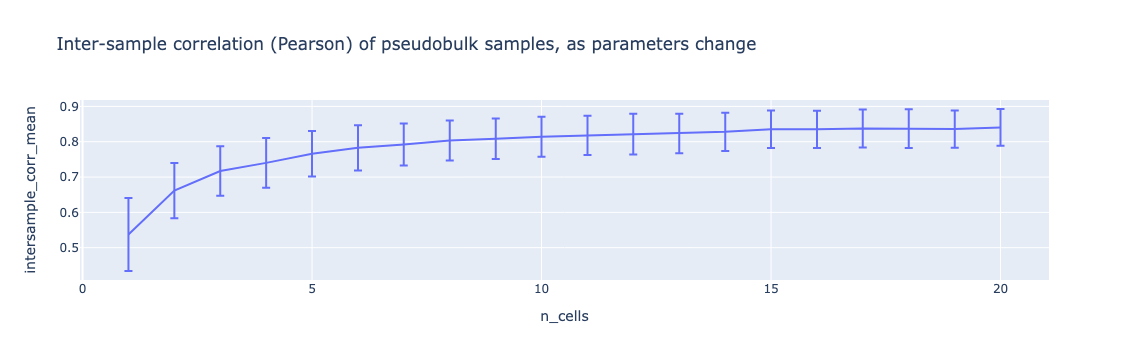

In [24]:
fig = px.line(
    results_intersample.reset_index().query("malignant_from_one_sample == True"),
    x="n_cells",
    y="intersample_corr_mean",
    error_y="intersample_corr_stddev",
    title="Inter-sample correlation (Pearson) of pseudobulk samples, as parameters change",
)
fig

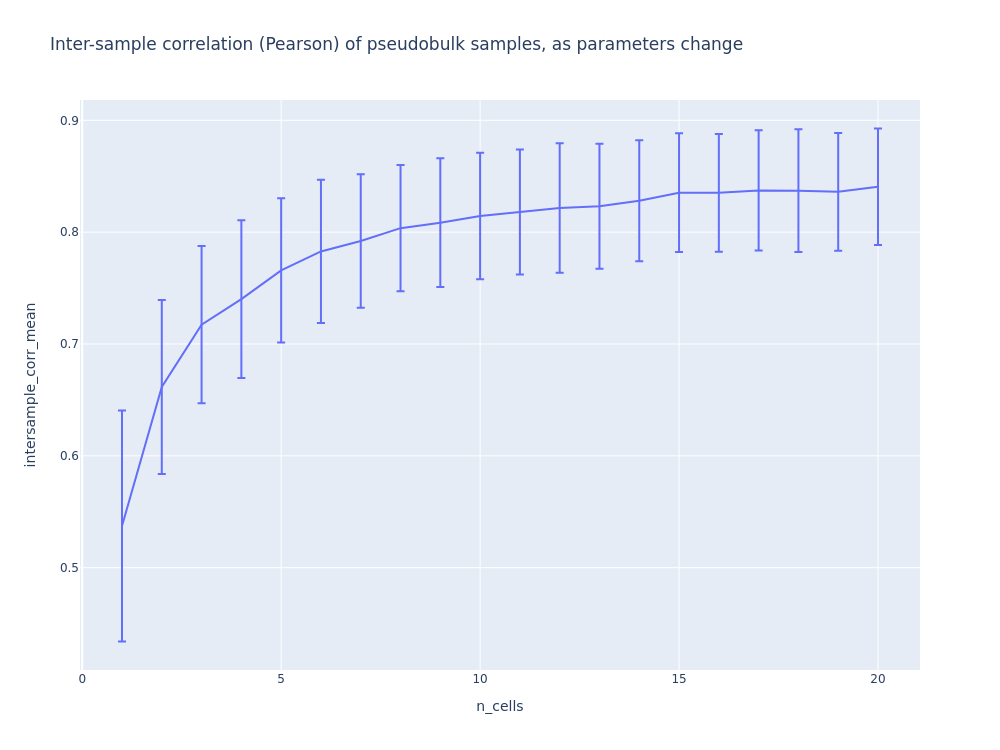

In [33]:
fig.show(renderer="png", scale=1, width=1000, height=750)